In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform
from tqdm import tqdm

# potential
def V(x):
    return 0.25 * x**4 - 0.5 * x**2

# gradient of potential
def grad_log_p(x):
    return x - x**3

In [7]:
def svgd_kernel(theta, h = -1):
    # pairwise dists
    sq_dist = squareform(pdist(theta)) ** 2

    # median trick
    if h < 0:
        h = np.sqrt(0.5 * np.median(sq_dist) / np.log(theta.shape[0] + 1))

    # kernel RBF
    K = np.exp(-sq_dist / (2 * h**2))

    # kernel derivative
    grad_K = -(K @ theta) + theta * np.sum(K, axis=1, keepdims=True)
    grad_K /= h**2

    return K, grad_K

In [8]:
def svgd_update(particles, grad_logp, n_iter=1000, stepsize=1e-2, n_frame=5):
    theta = np.copy(particles)
    fudge_factor = 1e-6
    historical_grad = 0

    saved_particles = []
    save_every = n_iter // n_frame

    for i in tqdm(range(n_iter), desc="SVGD Progress"):
        grad_logp_vals = grad_logp(theta)

        K, grad_K = svgd_kernel(theta)
        grad_theta = (K @ grad_logp_vals + grad_K) / theta.shape[0]

        if i == 0:
            historical_grad = grad_theta ** 2
        else:
            historical_grad = 0.9 * historical_grad + 0.1 * (grad_theta ** 2)

        adj_grad = grad_theta / (fudge_factor + np.sqrt(historical_grad))
        theta += stepsize * adj_grad

        if i % save_every == 0:
            saved_particles.append(np.copy(theta))

    return theta, saved_particles

In [9]:
# initialization
N = 1000
particles = np.random.randn(N, 1)

# execution of SVGD
final_particles, frames = svgd_update(particles, grad_log_p, n_iter=1000, n_frame=5)

SVGD Progress: 100%|██████████| 1000/1000 [00:17<00:00, 57.30it/s]


/var/folders/gd/b2d40bms7s3f8y4f31x7pk1r0000gn/T/ipykernel_80064/3659251566.py:3: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  true_density /= np.trapz(true_density, x_vals)


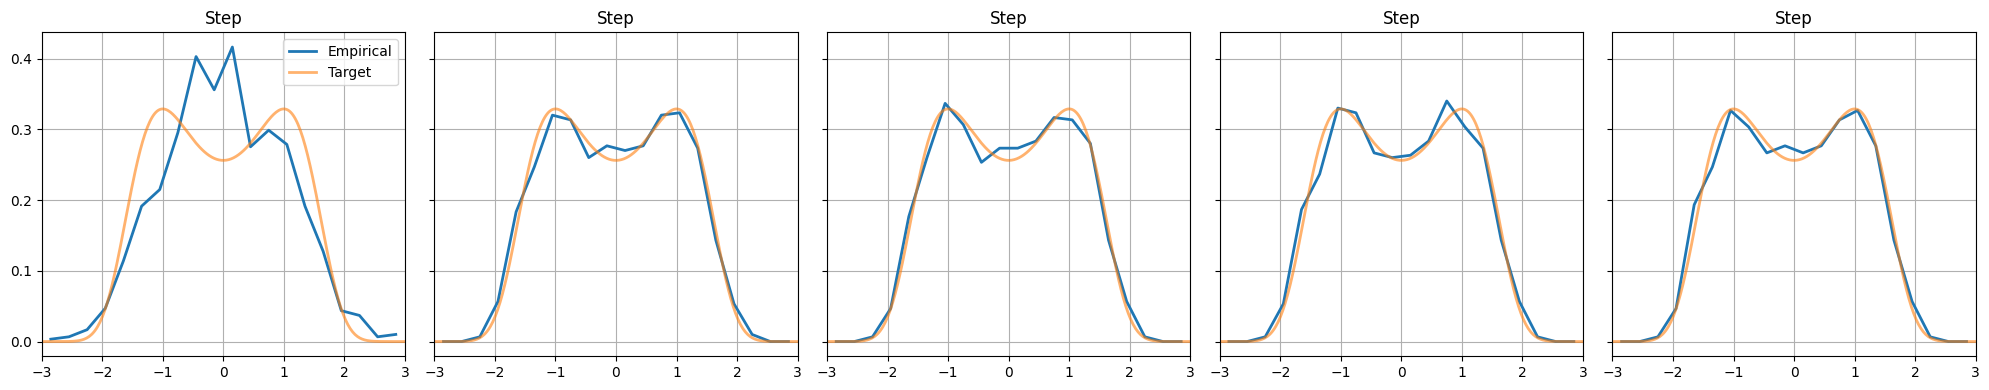

In [10]:
x_vals = np.linspace(-3, 3, 300)
true_density = np.exp(-V(x_vals))
true_density /= np.trapz(true_density, x_vals)

fig, axes = plt.subplots(1, len(frames), figsize=(20, 4), sharey=True)

for ax, step_particles in zip(axes, frames):
    hist_vals, bins = np.histogram(step_particles, bins=20, density=True, range=(-3, 3))
    bin_centers = 0.5 * (bins[:-1] + bins[1:])
    
    ax.plot(bin_centers, hist_vals, label="Empirical", lw=2)
    ax.plot(x_vals, true_density, label="Target", lw=2, alpha=0.6)
    ax.set_title("Step")
    ax.set_xlim(-3, 3)
    ax.grid(True)

axes[0].legend()
plt.tight_layout()
plt.show()
